In [1]:
UNKNOWN_CATEGORICAL_VALUE = 'N/A'
OTHERS_CATEGORICAL_VALUE = 'OTHERS'

In [2]:
from datetime import datetime

import pandas as pd

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def parser(s):
    if pd.isna(s):
        return
    if len(s) <= 10:
        return datetime.strptime(s, '%Y-%m-%d')
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')


In [5]:
columns_to_use = ['isAttended', 'UniqueID', 'acct_type_desc', 'event_name', 'event_date', 'plan_event_name', 
                  'comp_name', 'PC1', 'Price', 'paid', 'add_datetime', 'class_name', 'status', 'isHost', 
                  'SeatType', 'TicketClass', 'Term', 'TicketType', 'Season', 'Tenure', 'Resold', 'ResalePrice', 
                  'ResaleDate', 'isSTM']

In [6]:
df = pd.read_csv('Cross Road Analytics Competition Dataset.csv',
                 low_memory=False,
                 usecols=columns_to_use,
                 parse_dates=['event_date', 'add_datetime', 'ResaleDate'],
                 date_parser=parser)

In [7]:
df['isAttended'].value_counts(dropna=False, normalize=True)*100

Yes    70.008066
No     19.992214
???     9.999720
Name: isAttended, dtype: float64

# Feature Engineering

## acct_type_desc

In [8]:
df['acct_type_desc'] = df['acct_type_desc'].fillna(UNKNOWN_CATEGORICAL_VALUE)

In [9]:
# (df['acct_type_desc'].value_counts(dropna=False, normalize=True)*100).head(8).index

In [10]:
condition = df['acct_type_desc'].isin(
    ['Season', 'Club', 'House', 'N/A', 'Personal', 'Sponsor', 'Group', 'Employee']
)

df['acct_type_desc_processed'] = df['acct_type_desc']
df.loc[~condition, 'acct_type_desc_processed'] = OTHERS_CATEGORICAL_VALUE

In [13]:
# (df['acct_type_desc_processed'].value_counts(dropna=False, normalize=True)*100)#.head(8).index

## event_date, add_datetime, ResaleDate

variable name	variable description
event_date	Date of Game
add_datetime	Date/Time of Sale
ResaleDate	Date the ticket was resold 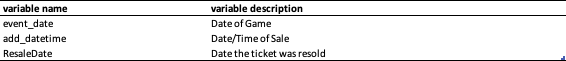

In [14]:
def get_date_diff(row, greater_date, lesser_date):
    event_date = row[greater_date]
    add_datetime = row[lesser_date]
    if pd.isna(event_date) or pd.isna(add_datetime):
        return
    add_datetime = add_datetime.date()
    event_date = event_date.date()
    return (event_date - add_datetime).days


df['event_sale_date_diff'] = df.apply(
    lambda x: get_date_diff(x, greater_date='event_date', lesser_date='add_datetime'), axis=1)
df['event_resale_date_diff'] = df.apply(
    lambda x: get_date_diff(x, greater_date='event_date', lesser_date='ResaleDate'), axis=1)
df['sale_resale_date_diff'] = df.apply(
    lambda x: get_date_diff(x, greater_date='ResaleDate', lesser_date='add_datetime'), axis=1)


## plan_event_name

In [15]:
df['plan_event_name'] = df['plan_event_name'].fillna(UNKNOWN_CATEGORICAL_VALUE)

In [16]:
condition = df['plan_event_name'].isin(['22FS', '21FS', 'N/A'])

df['plan_event_name_processed'] = df['plan_event_name']
df.loc[~condition, 'plan_event_name_processed'] = OTHERS_CATEGORICAL_VALUE

In [19]:
# (df['plan_event_name_processed'].value_counts(dropna=False, normalize=True)*100)

## comp_name

In [21]:
df['comp_name'] = df['comp_name'].fillna(UNKNOWN_CATEGORICAL_VALUE)

In [24]:
condition = df['comp_name'].isin(['Not Comp', 'N/A'])

df['comp_name_processed'] = df['comp_name']
df.loc[~condition, 'comp_name_processed'] = OTHERS_CATEGORICAL_VALUE

In [27]:
# df['comp_name_processed'].value_counts(dropna=False, normalize=True)*100

## Price

<AxesSubplot: ylabel='Frequency'>

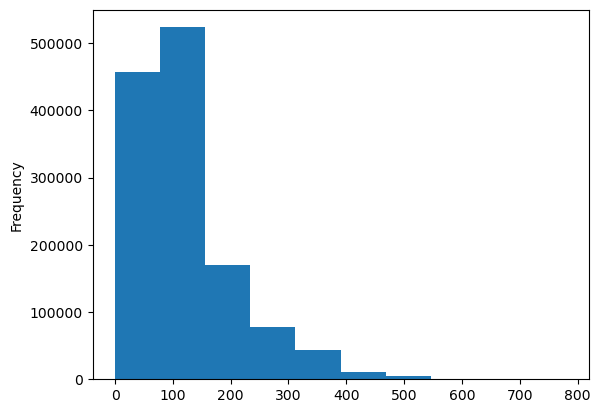

In [32]:
df['Price'].plot(kind='hist')

In [33]:
price_bins = [0, 100, 200, 300, 400, 500, float('inf')]
df['price_bins'] = pd.cut(df['Price'],
                          bins=price_bins,
                          include_lowest=True,
                          labels=['A', 'B', 'C', 'D', 'E', 'F'])

## Paid

In [38]:
df['paid'] = df['paid'].fillna(UNKNOWN_CATEGORICAL_VALUE)

In [42]:
df['paid'].value_counts(dropna=False, normalize=False)*100

Y      107557100
N/A     15414500
N        5668600
P          51400
Name: paid, dtype: int64

## class_name

In [44]:
df['class_name'] = df['class_name'].fillna(UNKNOWN_CATEGORICAL_VALUE)

In [52]:
condition = df['class_name'].isin(
    ['OPEN', 'JIM IRSAY', 'DIST-OPEN', 'ACCOUNT MANAGER', 'ACCMAN RELO', 'GROUP',
     'VT SELL', 'EVENTS', 'DOQ-BRDCSTHOLD', 'XTEST']
)

df['class_name_processed'] = df['class_name']
df.loc[~condition, 'class_name_processed'] = OTHERS_CATEGORICAL_VALUE

In [55]:
# (df['class_name_processed'].value_counts(dropna=False, normalize=True)*100)

## TicketClass

In [57]:
df.loc[df['TicketClass'] == 'Obstructed View', 'TicketClass'] = 'Obstruct'

In [58]:
df['TicketClass'].value_counts(dropna=False, normalize=True)*100

Manifest    92.525542
Infill       3.663021
SRO          1.561640
ADA          1.179564
Obstruct     1.070233
Name: TicketClass, dtype: float64

## TicketType

In [61]:
condition = df['TicketType'].isin(
    ['Renewal', 'New', 'Broker', 'Existing', 'SingleGame', 'Comp', 'Sponsor',
     'Group', 'SingleGm Avail', 'SRO Avail']
)

df['TicketType_processed'] = df['TicketType']
df.loc[~condition, 'TicketType_processed'] = OTHERS_CATEGORICAL_VALUE

## Resold

In [69]:
df['Resold'] = df['Resold'].fillna(UNKNOWN_CATEGORICAL_VALUE)

In [67]:
df.loc[df['Resold'] == '1', 'Resold'] = 'Yes'

In [70]:
df['Resold'].value_counts(dropna=False, normalize=True)

N/A    0.886513
Yes    0.113487
Name: Resold, dtype: float64

## isSTM

In [73]:
df['isSTM'] = df['isSTM'].fillna(0.)

In [74]:
df['isSTM'].value_counts(dropna=False, normalize=True)

0.0    0.699427
1.0    0.300573
Name: isSTM, dtype: float64

In [79]:
df['isSTM'] = df['isSTM'].apply(lambda x: str(x))

## isHost, Season

In [77]:
df['isHost'] = df['isHost'].apply(lambda x: str(x))

In [78]:
df['Season'] = df['Season'].apply(lambda x: str(x))

# Feature Selection

In [75]:
df.head()

,acct_type_desc,event_name,event_date,plan_event_name,comp_name,PC1,Price,paid,add_datetime,class_name,status,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,UniqueID,isAttended,Resold,ResalePrice,ResaleDate,isSTM,acct_type_desc_processed,event_sale_date_diff,event_resale_date_diff,sale_resale_date_diff,plan_event_name_processed,comp_name_processed,price_bins,class_name_processed,TicketType_processed
0,Season,CLT21HOU,2021-10-17,21FS,Not Comp,F,111.0,Y,2021-03-31 16:08:52,OPEN,SOLD,0,GA,Manifest,NaN,Renewal,2021,25.0,CLT21HOU-101-10-1,Yes,N/A,NaN,NaT,0.0,Season,200.0,NaN,NaN,21FS,Not Comp,B,OPEN,Renewal
1,Season,CLT21HOU,2021-10-17,21FS,Not Comp,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-10,No,N/A,NaN,NaT,0.0,Season,200.0,NaN,NaN,21FS,Not Comp,B,OPEN,Renewal
2,Season,CLT21HOU,2021-10-17,21FS,Not Comp,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-11,No,N/A,NaN,NaT,0.0,Season,200.0,NaN,NaN,21FS,Not Comp,B,OPEN,Renewal
3,Season,CLT21HOU,2021-10-17,21FS,Not Comp,F,111.0,Y,2021-03-31 16:10:20,OPEN,SOLD,0,GA,Manifest,NaN,Renewal,2021,4.0,CLT21HOU-101-10-12,Yes,N/A,NaN,NaT,0.0,Season,200.0,NaN,NaN,21FS,Not Comp,B,OPEN,Renewal
4,Season,CLT21HOU,2021-10-17,21FS,Not Comp,F,111.0,Y,2021-03-31 16:08:21,OPEN,SOLD,0,GA,Manifest,NaN,Renewal,2021,32.0,CLT21HOU-101-10-13,No,N/A,NaN,NaT,0.0,Season,200.0,NaN,NaN,21FS,Not Comp,B,OPEN,Renewal


In [80]:
selected_columns = ['UniqueID', 'isAttended','event_name', 'PC1', 'Price', 'paid', 'status', 'isHost', 
                    'SeatType', 'TicketClass', 'Term', 'Season', 'Tenure', 
                    'Resold', 'ResalePrice', 'isSTM', 'acct_type_desc_processed',
                    'event_sale_date_diff', 'event_resale_date_diff', 'sale_resale_date_diff',
                    'plan_event_name_processed', 'comp_name_processed', 'class_name_processed', 
                    'TicketType_processed']

In [82]:
df[selected_columns].sample(10)

,UniqueID,isAttended,event_name,PC1,Price,paid,status,isHost,SeatType,TicketClass,Term,Season,Tenure,Resold,ResalePrice,isSTM,acct_type_desc_processed,event_sale_date_diff,event_resale_date_diff,sale_resale_date_diff,plan_event_name_processed,comp_name_processed,class_name_processed,TicketType_processed
901573,CLT22PHI-101-SR1-30,No,CLT22PHI,W,37.0,N/A,AVAIL,0,GA,SRO,NaN,2022,NaN,N/A,NaN,0.0,N/A,NaN,NaN,NaN,N/A,N/A,OTHERS,OTHERS
1102520,CLT22PR2-125-12-15,Yes,CLT22PR2,F,70.0,Y,SOLD,0,GA,Manifest,NaN,2022,37.0,N/A,NaN,1.0,Season,262.0,NaN,NaN,22FS,Not Comp,OPEN,Renewal
185846,CLT21LAR-629-16-4,Yes,CLT21LAR,T,53.0,Y,SOLD,0,GA,Manifest,NaN,2021,2.0,N/A,NaN,0.0,Personal,2.0,NaN,NaN,N/A,Not Comp,OTHERS,Group
298939,CLT21NE-451-19-22,Yes,CLT21NE,N,118.0,N/A,SOLD,1,GA,Manifest,NaN,2021,1.0,N/A,NaN,0.0,Personal,7.0,NaN,NaN,N/A,Not Comp,DIST-OPEN,SingleGame
1245294,CLT22WAS-227-13-9,Yes,CLT22WAS,G,107.0,Y,SOLD,0,GA,Manifest,NaN,2022,8.0,N/A,NaN,1.0,Season,193.0,NaN,NaN,22FS,Not Comp,ACCMAN RELO,Renewal
1233949,CLT22WAS-136-3-10,Yes,CLT22WAS,B,161.0,Y,SOLD,0,GA,Manifest,NaN,2022,3.0,N/A,NaN,1.0,Season,356.0,NaN,NaN,22FS,Not Comp,OPEN,Renewal
80022,CLT21JAX-148-17-11,Yes,CLT21JAX,F,111.0,Y,SOLD,0,GA,Manifest,NaN,2021,1.0,N/A,NaN,0.0,Season,165.0,NaN,NaN,21FS,Not Comp,ACCOUNT MANAGER,New
1169684,CLT22TEN-136-6-19,Yes,CLT22TEN,B,179.0,Y,SOLD,0,GA,Manifest,NaN,2022,4.0,N/A,NaN,1.0,Season,293.0,NaN,NaN,22FS,Not Comp,OPEN,Renewal
993700,CLT22PIT-320-2-5,Yes,CLT22PIT,I,124.0,Y,SOLD,0,GA,Manifest,NaN,2022,13.0,N/A,NaN,1.0,Season,332.0,NaN,NaN,22FS,Not Comp,OPEN,Renewal
1068648,CLT22PR1-439-8-4,Yes,CLT22PR1,8,169.0,Y,SOLD,0,Club,Manifest,3.0,2022,0.0,N/A,NaN,0.0,Club,187.0,NaN,NaN,22FS,Not Comp,OTHERS,New


In [83]:
df[selected_columns].dtypes

UniqueID                      object
isAttended                    object
event_name                    object
PC1                           object
Price                        float64
paid                          object
status                        object
isHost                        object
SeatType                      object
TicketClass                   object
Term                         float64
Season                        object
Tenure                       float64
Resold                        object
ResalePrice                  float64
isSTM                         object
acct_type_desc_processed      object
event_sale_date_diff         float64
event_resale_date_diff       float64
sale_resale_date_diff        float64
plan_event_name_processed     object
comp_name_processed           object
class_name_processed          object
TicketType_processed          object
dtype: object

In [87]:
df[selected_columns].to_csv('dataset_processed_v1.csv', index=False)